In [1]:
import json
# from collections import defaultdict
from sklearn import linear_model
# from sklearn.linear_model import LinearRegression
import numpy
import gzip
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
f = gzip.open("renttherunway_final_data.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))
f.close()

In [3]:
dataset[0]

{'fit': 'fit',
 'user_id': '420272',
 'bust size': '34d',
 'item_id': '2260466',
 'weight': '137lbs',
 'rating': '10',
 'rented for': 'vacation',
 'review_text': "An adorable romper! Belt and zipper were a little hard to navigate in a full day of wear/bathroom use, but that's to be expected. Wish it had pockets, but other than that-- absolutely perfect! I got a million compliments.",
 'body type': 'hourglass',
 'review_summary': 'So many compliments!',
 'category': 'romper',
 'height': '5\' 8"',
 'size': 14,
 'age': '28',
 'review_date': 'April 20, 2016'}

## How does the age of users influence their ratings of clothing items rented from Rent the Runway?

In [4]:
clean_dataset = []
for d in dataset:
    if 'age' in d and 'rating' in d and str(d['age']).isdigit() and str(d['rating']).isdigit():
        clean_dataset.append(d)

In [5]:
ages = [int(d['age']) for d in clean_dataset]
ratings = [int(d['rating']) for d in clean_dataset]

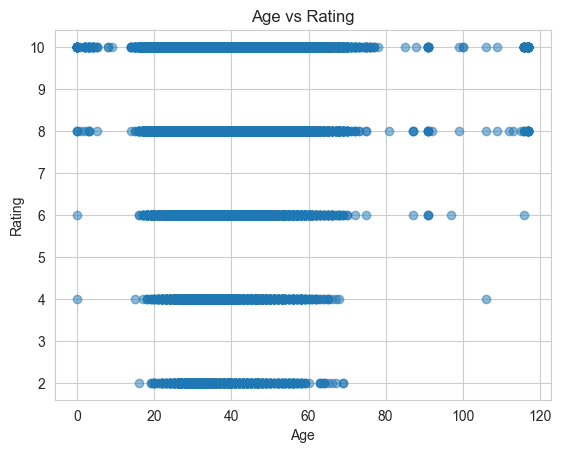

In [6]:
plt.scatter(ages, ratings, alpha=0.5)
plt.title('Age vs Rating')
plt.xlabel('Age')
plt.ylabel('Rating')
plt.show()

In [7]:
# Prepare the data for linear regression
X = numpy.array([[1, age] for age in ages])  # Including the constant term
y = numpy.array(ratings).reshape(-1, 1)

In [8]:
model = linear_model.LinearRegression(fit_intercept=False)
model.fit(X, y)

LinearRegression(fit_intercept=False)

In [9]:
theta = model.coef_
theta

array([[ 9.30426074e+00, -6.26219615e-03]])

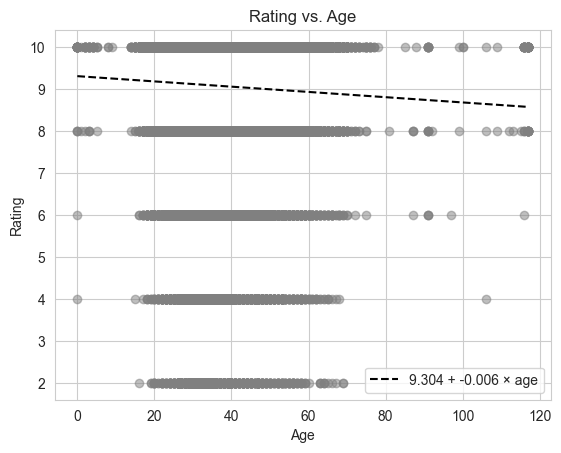

In [10]:
xplot = numpy.arange(min(ages), max(ages)+1)
yplot = [theta[0,0] + theta[0,1]*x for x in xplot]
plt.scatter(ages, ratings, color='grey', alpha=0.5)
plt.plot(xplot, yplot, color='k', linestyle='--', label=f"{theta[0,0]:.3f} + {theta[0,1]:.3f} × age")
plt.xlabel("Age")
plt.ylabel("Rating")
plt.title("Rating vs. Age")
plt.legend(loc='lower right')
plt.show()

In [11]:
df = pd.DataFrame(dataset)

## How do customer preferences and satisfaction, as indicated by the fit of rented items for different purposes, correlate with the overall trend in service usage over time?

In [12]:
# Convert 'review_date' to datetime
df['review_date'] = pd.to_datetime(df['review_date'])

In [13]:
# Set the review_date as the index
df.set_index('review_date', inplace=True)

In [14]:
# Sort the data by date to prepare for the time series analysis
df.sort_index(inplace=True)

In [15]:
# Aggregating data by month to see the trend more clearly
monthly_data = df.resample('M').size()

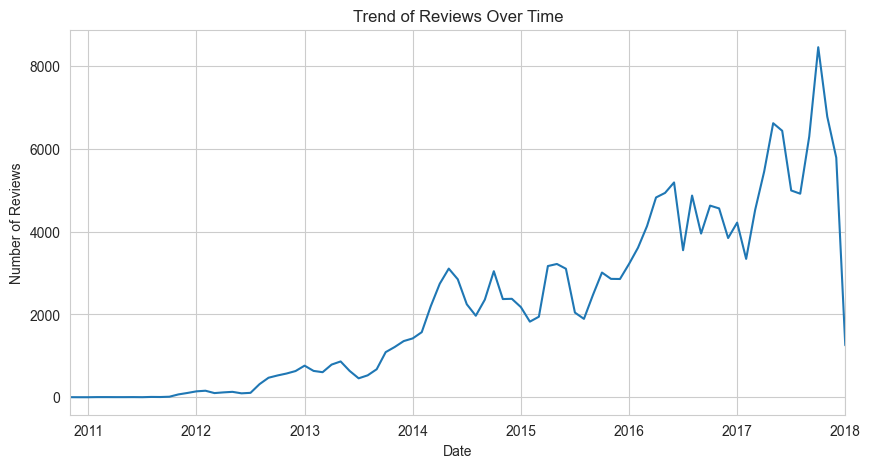

In [16]:
# Plotting the trend of reviews over time
plt.figure(figsize=(10, 5))
monthly_data.plot(title='Trend of Reviews Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

In [17]:
# Replace 'nan' string with actual NaN and drop those rows
df['rented for'] = df['rented for'].replace('NaN', pd.NA)
df.dropna(subset=['rented for'], inplace=True)

In [18]:
# We will create a cross-tabulation of the 'fit' variable with the 'rented for' category
fit_rented_for_crosstab = pd.crosstab(df['fit'], df['rented for'])
fit_rented_for_crosstab

rented for,date,everyday,formal affair,other,party,party: cocktail,vacation,wedding,work
fit,,,,,,,,,
fit,5261,11608,31089,11334,25874,1,2914,43111,10857
large,935,3563,4451,2038,4546,0,669,6200,2304
small,1192,1651,4868,2016,5206,0,492,8473,1881


C:\Users\Nhat\AppData\Local\Temp\ipykernel_1548\1375075121.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  ax.figure.show()


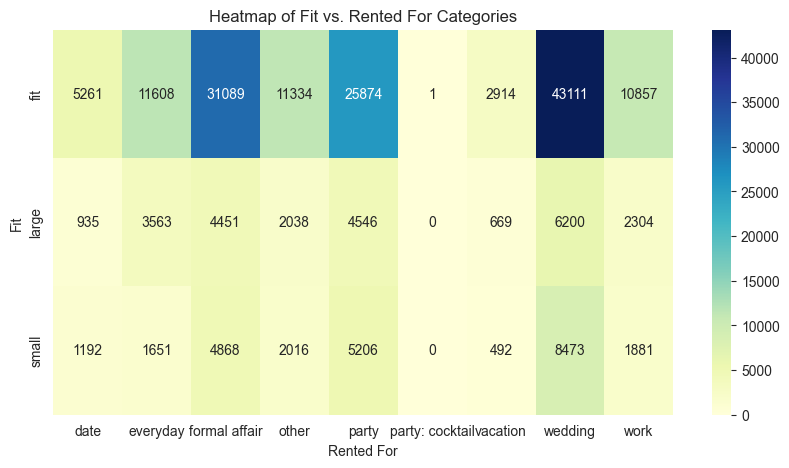

In [19]:
# Visualizing the cross-tabulation with a heatmap
plt.figure(figsize=(10, 5))

ax = sns.heatmap(fit_rented_for_crosstab, annot=True, fmt="d", cmap="YlGnBu")

# Set title and labels
ax.set_title('Heatmap of Fit vs. Rented For Categories')
ax.set_xlabel('Rented For')
ax.set_ylabel('Fit')

# Display the plot
ax.figure.show()

## How does age and review length correlate and how does it affect the overall rating of rented items?

In [20]:
clean_dataset = []
for d in dataset:
    if 'age' in d and 'review_text' in d and str(d['age']).isdigit():
        clean_dataset.append(d)

In [21]:
ages = [int(d['age']) for d in clean_dataset]
reviewLen = [len(d['review_text']) for d in clean_dataset]

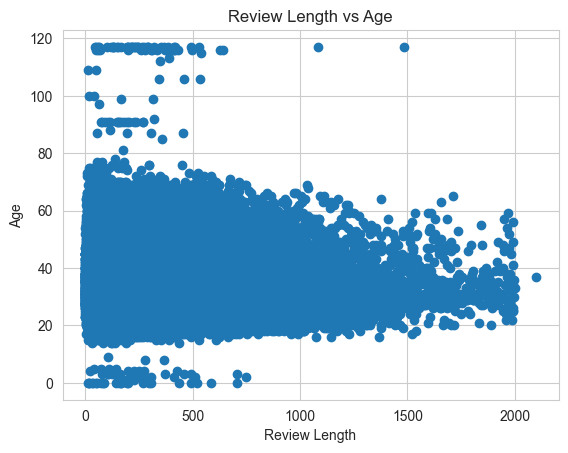

In [22]:
plt.scatter(reviewLen, ages)
plt.xlabel('Review Length')
plt.ylabel('Age')
plt.title('Review Length vs Age')

plt.show()

In [23]:
clean_dataset = []
for d in dataset:
    if 'rating' in d and 'review_text' in d and str(d['rating']).isdigit():
        clean_dataset.append(d)

In [24]:
ratings = [int(d['rating']) for d in clean_dataset]
reviewLen = [len(d['review_text']) for d in clean_dataset]

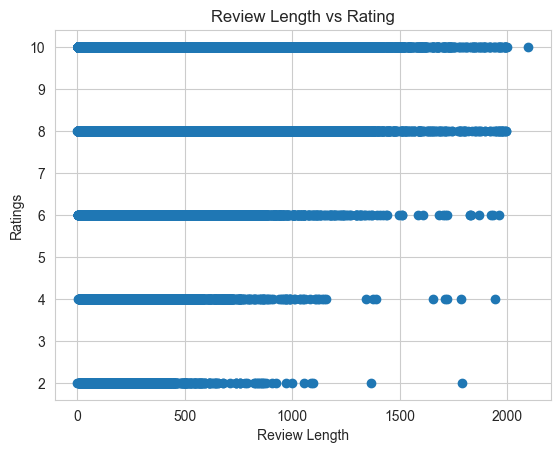

In [25]:
plt.scatter(reviewLen, ratings)
plt.xlabel('Review Length')
plt.ylabel('Ratings')
plt.title('Review Length vs Rating')

plt.show()

## What are the distribution of rating scores?

In [26]:
score_freq = df.groupby('rating').count().reset_index()
score_freq['rating'] = score_freq['rating'].astype(int)

score_freq = score_freq.sort_values(by='rating')

score_freq

,rating,fit,user_id,bust size,item_id,weight,rented for,review_text,body type,review_summary,category,height,size,age
1,2,1045,1045,945,1045,856,1045,1045,988,1045,1045,1037,1045,1041
2,4,2791,2791,2546,2791,2401,2791,2791,2622,2791,2791,2777,2791,2777
3,6,10697,10697,9773,10697,9111,10697,10697,10059,10697,10697,10657,10697,10650
4,8,53388,53388,48383,53388,45042,53388,53388,49663,53388,53388,53203,53388,53125
0,10,124531,124531,112411,124531,105085,124531,124531,114483,124531,124531,124101,124531,123900


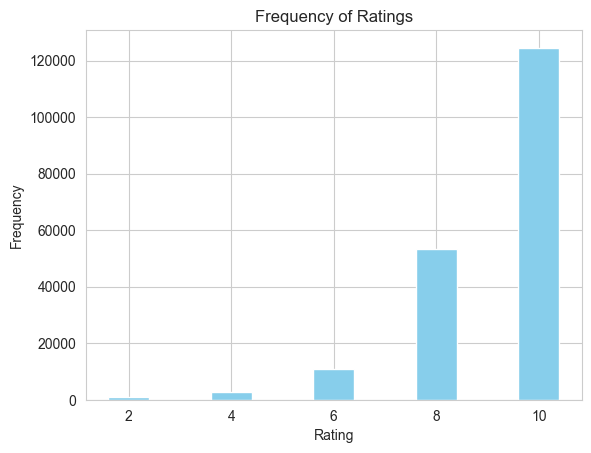

In [27]:
plt.bar(score_freq['rating'], score_freq['user_id'], color='skyblue')

# Add labels and title
plt.title('Frequency of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()

## What are the review averages based on age group?

In [28]:
df

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age
review_date,,,,,,,,,,,,,,
2010-11-03,fit,119679,36d,125564,NaN,10,wedding,This dress is amazing! I received so many comp...,hourglass,excellent customer servuce,gown,"5' 8""",25,38
2011-02-14,fit,635759,36c,126335,NaN,8,formal affair,This dress was beautiful! It's a little more p...,pear,"Stop, drop and stare. I got looks all night in...",dress,"5' 5""",16,38
2011-02-23,fit,201407,34b,126335,125lbs,10,formal affair,Amazing dress!! True to size and fit like a dr...,hourglass,The dress was super comfortable and super gorg...,dress,"5' 8""",8,32
2011-02-24,fit,566811,36c,125564,155lbs,10,wedding,Fabulous dress. First time on Runway and this...,hourglass,So flattering!!,gown,"5' 6""",21,37
2011-03-06,fit,252516,NaN,190529,NaN,10,formal affair,I LOVED wearing this dress!!! Since I'm just 5...,hourglass,The perfect LBD.,dress,"5' 0""",14,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-06,fit,900541,36dd,2559060,130lbs,10,vacation,So cute! Recommend.,hourglass,Felt great in this top. So cute! Recommend.,top,"5' 3""",8,50
2018-01-07,large,578131,36c,2526611,129lbs,10,party,"Unlike some other reviewers, I wore a size sma...",hourglass,"Such a nice skirt, easy & comfy to wear.",skirt,"5' 6""",8,60
2018-01-07,fit,273288,NaN,2499759,192lbs,10,party,"NYE 2018! My bff wore this she loved the fit, ...",NaN,BFF loves RTR!,jumpsuit,"5' 6""",20,52


In [33]:
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df['age'] = pd.to_numeric(df['age'], errors='coerce')

df['rating'].fillna(df['rating'].mean(), inplace=True)
df['age'].fillna(df['age'].mean(), inplace=True)

# age_mean = df
# age_mean['rating'] = age_mean['rating'].fillna(0).astype(int)
# age_mean['rating'] = age_mean['rating'].astype(int)
age_mean = df.groupby('age')['rating'].mean().reset_index()
# age_mean['age'] = age_mean['age'].astype(int)

age_mean = age_mean.sort_values(by='age')

age_mean

,age,rating
0,0.0,9.333333
1,1.0,9.000000
2,2.0,9.800000
3,3.0,9.500000
4,4.0,10.000000
...,...,...
85,112.0,8.000000
86,113.0,8.000000
87,115.0,8.000000
88,116.0,9.444444


In [ ]:
plt.plot(age_mean['age'], age_mean['rating'], color='skyblue')

# Add labels and title
plt.title('Average review for each age')
plt.xlabel('age')
plt.ylabel('Mean review')

# Show the plot
plt.show()

## Predictive task for Fit of Clothing
#### Given the fit, user_id, bust size, item_id, rating, review_text, review_summary, size, age, review_date, can we predict if an item will fit well?

##### Baseline Model

In [30]:
column_to_drop = ['rented for', 'weight', 'height', 'body type', 'category']

In [31]:
df = df.drop(columns=column_to_drop, errors='ignore', axis=1)

In [35]:
df = df.dropna(subset=['size', 'age'])

In [36]:
X = df[['size', 'age']]
y = df['rating'].astype(float)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
model = linear_model.LogisticRegression()
model.fit(X_train, y_train)

C:\Users\Nhat\Documents\GitHub\Assignment-2\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [99]:
y_pred = model.predict(X_test)

In [105]:
correct = y_pred == y_test

In [106]:
accuracy = sum(correct)/len(correct)

In [107]:
print(f"Accuracy: {accuracy}")

Accuracy: 0.64614380790813


##### Ridge Model

In [81]:
ridge_model = linear_model.Ridge(alpha=1, random_state=42)

In [82]:
ridge_model.fit(X_train, y_train)

Ridge(alpha=1, random_state=42)

In [83]:
ridge_y_pred = ridge_model.predict(X_test)

In [108]:
correct_ridge = ridge_y_pred == y_test

In [109]:
ridge_accuracy = sum(correct_ridge)/len(correct_ridge)

In [110]:
print(f"Accuracy: {ridge_accuracy}")

Accuracy: 0.0


In [87]:
ridge_mse = sum((ridge_y_pred - y_test)**2)/len(y_test)
ridge_r2 = r2_score(y_test, ridge_y_pred)

In [88]:
print('Ridge Regression Metrics:')
print('Mean Squared Error (MSE):', ridge_mse)
print('R-squared:', ridge_r2)

Ridge Regression Metrics:
Mean Squared Error (MSE): 2.0647475603956735
R-squared: 0.002076904874614316


##### Random Forest Model

In [92]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [93]:
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

In [95]:
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

In [96]:
print('Random Forest Regressor Metrics:')
print('MSE:', rf_mse)
print('R2:', rf_r2)

Random Forest Regressor Metrics:
MSE: 2.072500436549011
R2: -0.0016701750665584214


In [ ]:
# df = df.dropna(subset=['height'])

In [ ]:
# df['height_inches'] = df['height'].str.extract(r'(\d+)\' (\d+)\"').apply(
#     lambda x: int(x[0]) * 12 + int(x[1]), axis=1
# )

In [ ]:
# df['weight_lbs'] = df['weight'].str.extract(r'(\d+)lbs').astype(float)

In [ ]:
# df = df.dropna(subset=['height_inches', 'weight_lbs', 'body type', 'size', 'fit'])

In [ ]:
# label_encoders = {}
# for column in ['body type', 'fit']:
#     label_encoders[column] = LabelEncoder()
#     df[column] = label_encoders[column].fit_transform(df[column])

In [ ]:
# fit_labels = {0: 'small', 1: 'fit', 2: 'large'}
# df['fit_label'] = df['fit'].replace(fit_labels)

In [ ]:
# X = df[['height_inches', 'weight_lbs', 'body type', 'size']]
# y = df['fit']

In [ ]:
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# model.fit(X_train, y_train)

In [ ]:
# y_pred = model.predict(X_test)

In [ ]:
# y_pred_labels = label_encoders['fit'].inverse_transform(y_pred)

In [ ]:
# accuracy = accuracy_score(y_test, y_pred)

In [ ]:
# y_test_labels = label_encoders['fit'].inverse_transform(y_test)

In [ ]:
# print(f"Accuracy: {accuracy}")
# print(classification_report(y_test_labels, y_pred_labels, target_names=['small', 'fit', 'large']))

#### How do customer preferences and satisfaction, as indicated by the fit of rented items for different purposes, correlate with the overall trend in service usage over time?

In [ ]:
# one_hot_encoder = OneHotEncoder()
# rented_for_encoded = one_hot_encoder.fit_transform(df[['rented for']]).toarray()

In [ ]:
# feature_names = one_hot_encoder.get_feature_names_out(['rented for'])

In [ ]:
# rented_for_df = pd.DataFrame(rented_for_encoded, columns=feature_names, index=df.index)

In [ ]:
# df = df.join(rented_for_df)

In [ ]:
# features = df[feature_names]
# labels = df['fit']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [ ]:
# model = linear_model.LogisticRegression(fit_intercept=False)
# model.fit(X_train, y_train)

In [ ]:
# Predict on the test set
# y_pred = model.predict(X_test)

In [ ]:
# accuracy = accuracy_score(y_test, y_pred)

In [ ]:
# print(f"Accuracy: {accuracy}")

In [ ]:
# df.columns

In [ ]:
# Drop the specified columns if they exist
# columns_to_drop = ['bust size', 'weight', 'rented for', 'body type', 'height', 'size']
# df = df.drop(columns=columns_to_drop, errors='ignore')

# Print the columns after the drop operation
# print(df.columns)

In [ ]:
# df['text_length'] = df['review_text'].apply(lambda x: len(x))
# df